In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import torch
import torch.utils.data
import torchvision
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from torchvision import transforms as T

In [ ]:
#import sys;sys.path.insert(0,r'/content/gdrive/My Drive')

In [3]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # filename for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # filename of input mask corresponding to the above image file
        mask_file_path = os.path.splitext(path)[0] + '.png'
        # open the input image
        img = Image.open(os.path.join(self.root, 'images',path)).convert('RGB')
        ## mask ##
        mask = Image.open(os.path.join(self.root,'masks',mask_file_path))
        # convert the PIL Image of mask into a numpy array
        # mask = np.array(mask)
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        iscrowd = []
        labels = []

        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
            iscrowd.append(coco_annotation[i]['iscrowd'])
            labels.append(coco_annotation[i]['category_id'])

        areas,iscrowd,labels = map(torch.tensor, [areas,iscrowd,labels])

        # split the color-encoded mask into a set of binary masks        
        #mask = self.transforms(mask)
        #masks = mask == labels[:, None, None]
        
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
        mask = mask.numpy().reshape(mask.shape,order='F')
        mask = torch.as_tensor(mask, dtype=torch.uint8)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        my_annotation["masks"] = mask
        
        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [4]:
def get_transform(train):
    custom_transforms = []
   # if train:
   #     custom_transforms.append(T.RandomHorizontalFlip(0.5))
    custom_transforms.append(T.ToTensor())
    return T.Compose(custom_transforms)

In [5]:
%cd '/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data'

/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data


In [6]:
# path to your own data and coco file
data_dir = r'/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data'
#mask_dir = r'/content/gdrive/My Drive/weapons_detection_1k/masks'
coco_instances = r'/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/coco_instances.json'

# create own Dataset
my_dataset = myOwnDataset(root=data_dir,
                          annotation=coco_instances,
                          transforms=get_transform(train=True))

#train-val split

samples = len(my_dataset)
test_counts = int(samples*.2)
train_counts = samples-test_counts
train_set, val_set = torch.utils.data.random_split(my_dataset, [train_counts, test_counts])

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [8]:
# collate_fn needed for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 10

# Train DataLoader
train_data_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=train_batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

#Category dictinoray for output tagging
instances = COCO(coco_instances)
categories = instances.loadCats(instances.getCatIds())
class_dict = {d['id']:d['name'] for d in categories}
print(class_dict)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
{1: 'pistels', 2: 'knifes'}


In [9]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    ## model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

In [10]:
# Number of categories and a background
num_classes = 1 + len(instances.getCatIds())

# number of epochs
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

model.to(device)
print('model sent to device')

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.08)


total_batches = len(train_data_loader)

# Model training
print('Training model..')
for epoch in range(num_epochs):
    print(f'Epoch no: {epoch}')
    model.train()
    i = 0    
    for imgs, annotations in train_data_loader:
        i += 1

        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Epoch no: {epoch}/{num_epochs-1}, Batch no: {i}/{total_batches}, Loss: {losses}')

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth



model sent to device
Training model..
Epoch no: 0
Epoch no: 0/0, Batch no: 1/80, Loss: 4.791574001312256
Epoch no: 0/0, Batch no: 2/80, Loss: 1.8159658908843994
Epoch no: 0/0, Batch no: 3/80, Loss: 1.3282976150512695
Epoch no: 0/0, Batch no: 4/80, Loss: 1.1661193370819092
Epoch no: 0/0, Batch no: 5/80, Loss: 1.116831660270691
Epoch no: 0/0, Batch no: 6/80, Loss: 1.1024283170700073
Epoch no: 0/0, Batch no: 7/80, Loss: 1.0664880275726318
Epoch no: 0/0, Batch no: 8/80, Loss: 1.048130750656128
Epoch no: 0/0, Batch no: 9/80, Loss: 1.0365161895751953
Epoch no: 0/0, Batch no: 10/80, Loss: 1.068894386291504
Epoch no: 0/0, Batch no: 11/80, Loss: 0.9385393857955933
Epoch no: 0/0, Batch no: 12/80, Loss: 0.9359803199768066
Epoch no: 0/0, Batch no: 13/80, Loss: 1.084341287612915
Epoch no: 0/0, Batch no: 14/80, Loss: 0.8914982080459595
Epoch no: 0/0, Batch no: 15/80, Loss: 0.956291913986206
Epoch no: 0/0, Batch no: 16/80, Loss: 1.0207189321517944
Epoch no: 0/0, Batch no: 17/80, Loss: 0.935333311557

In [14]:
import torch
torch.save(model,'/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/maskrcnn_saved_model.pth')

In [15]:
import torch
model = torch.load('/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/maskrcnn_saved_model.pth')
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [ ]:
# #Validation
# from detection_pytorch_repo import engine

# # Validation DataLoader
# val_data_loader = torch.utils.data.DataLoader(val_set,
#                                           batch_size=train_batch_size,
#                                           shuffle=False,
#                                           collate_fn=collate_fn,
#                                           num_workers=4)

In [ ]:
# #Evaluating the model on the validation set
# engine.evaluate(model, val_data_loader, device=device)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#class_dict = {1: 'pistels', 2: 'knifes'}
cat_names = ['__background__','pistels','knifes']

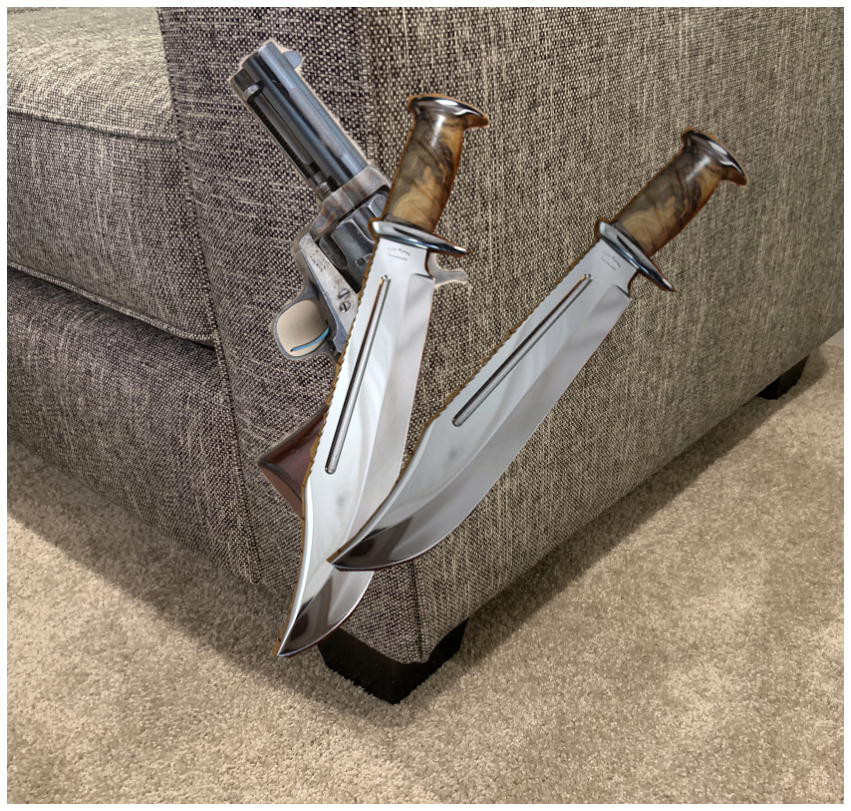

In [18]:
#Inference

from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

loc = r'/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/images/00000000.png'
im  = Image.open(loc)
model.eval()
transform = T.Compose([T.ToTensor()])
image = transform(im)

image = image.to(device)
result = model([image])
#print(result)
#pred_masks = [i ]
pred_score = [i for i in result[0]['scores'].detach().to('cpu').numpy() if i > 0.60]
pred_class = result[0]['labels'][:len(pred_score)]
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(result[0]['boxes'].detach().to('cpu').numpy())][:len(pred_score)]

im = np.array(im)
for i in range(len(pred_class)):
  color = np.random.randint(0, high = 256, size = (3,)).tolist ()
  cv2.rectangle(im, pred_boxes[i][0], pred_boxes[i][1],color,5) # Draw Rectangle with the coordinates
  cat = class_dict[pred_class[i].item()]
  text_position = int(pred_boxes[i][1][0]-30),int(pred_boxes[i][1][1]-10)
  sub_text = str(np.round(pred_score[i],4))
  sub_text_position = text_position[0],text_position[1]+50
  cv2.putText(im, cat, text_position,  cv2.FONT_HERSHEY_SIMPLEX, 3, color,3,cv2.LINE_AA) # Write the prediction class
  cv2.putText(im, sub_text, sub_text_position,  cv2.FONT_HERSHEY_SIMPLEX, 1.5, color,1,cv2.LINE_AA)
plt.figure(figsize=(15,18)) # display the output image

plt.imshow(im)
plt.axis("off")
plt.show()

In [19]:
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random





def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    img = img.cuda()
    
    
    pred = model([img])
    print('pred: ',pred)
    pred_score = list(pred[0]['scores'].detach().to('cpu').numpy())
    print('pred_score: ',pred_score)
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    print('pred_t:',pred_t)
    
    masks = (pred[0]['masks']>0.5).squeeze().detach().to('cpu').numpy()
    print('masks:',masks)
    print('masks shape from output: ', pred[0]['masks'].shape)
    pred_class = [cat_names[i] for i in list(pred[0]['labels'].detach().to('cpu').numpy())]
    print('pred_class: ',pred_class)
    
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().to('cpu').numpy())]
    print('pred_boxes: ',pred_boxes)
    masks = masks[:pred_t+1]
    #print('masks with threshold:',masks)
    pred_boxes = pred_boxes[:pred_t+1]
    print('pred_boxes:',pred_boxes)
    pred_class = pred_class[:pred_t+1]
    print('pred_class: ',pred_class)
    return masks, pred_boxes, pred_class

In [20]:
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [ ]:
# other options:
 ####################33yoloact
 #######################33detectron


In [21]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    #print(masks.shape)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
instance_segmentation_api('/content/gdrive/MyDrive/DEEPLOBE/segmentation/maskrcnn_pistol_data/images/00000000.png', 0.5)

In [ ]:
nmask = (result[0]['masks']>0.5).squeeze().detach().cpu().numpy()

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=840x800 at 0x7F6C05399DA0>


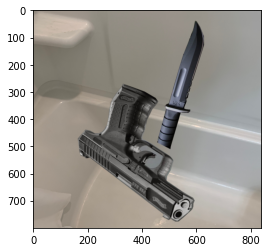

In [ ]:
img = r'/content/gdrive/My Drive/maskrcnn_pistol_data1/images/00000161.png'
im  = Image.open(img)
print(im)
plt.imshow(im)

In [ ]:
#img,_ = my_dataset[161]

In [ ]:
#Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
result[0]['masks'].shape

torch.Size([3, 1, 800, 840])

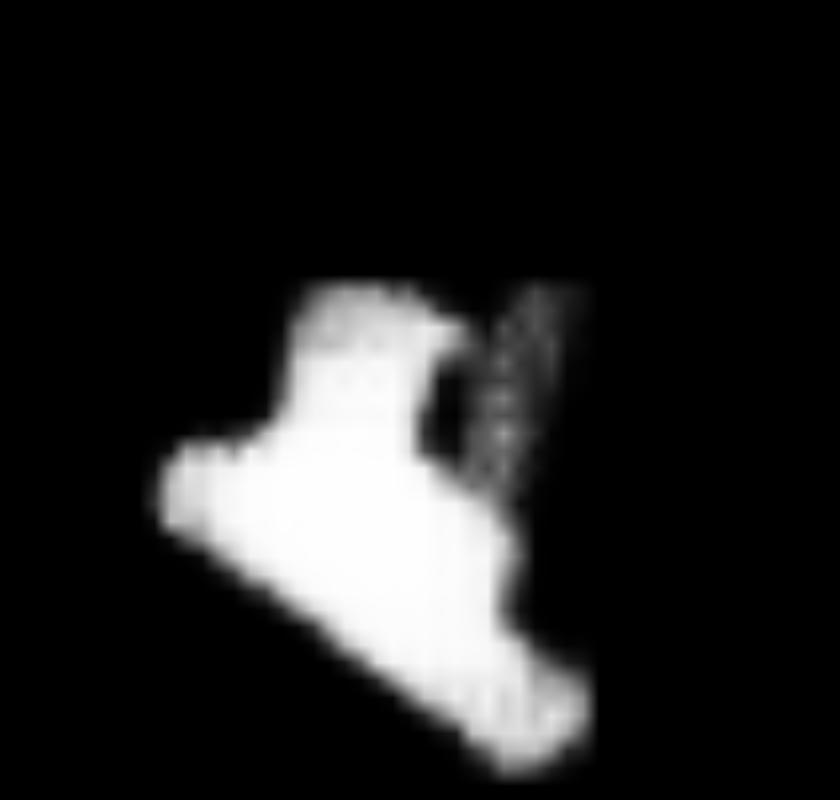

In [ ]:
Image.fromarray(result[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

tensor([[         0,          0,          0],
        [  33554431,      32767,    2097151],
        [  67108862,      65534,    4194302],
        [ 100663293,      98301,    6291453],
        [ 134217724,     131068,    8388604],
        [ 167772155,     163835,   10485755],
        [ 201326586,     196602,   12582906],
        [ 234881017,     229369,   14680057],
        [ 268435448,     262136,   16777208],
        [ 301989879,     294903,   18874359],
        [ 335544310,     327670,   20971510],
        [ 369098741,     360437,   23068661],
        [ 402653172,     393204,   25165812],
        [ 436207603,     425971,   27262963],
        [ 469762034,     458738,   29360114],
        [ 503316465,     491505,   31457265],
        [ 536870896,     524272,   33554416],
        [ 570425327,     557039,   35651567],
        [ 603979758,     589806,   37748718],
        [ 637534189,     622573,   39845869],
        [ 671088620,     655340,   41943020],
        [ 704643051,     688107,  

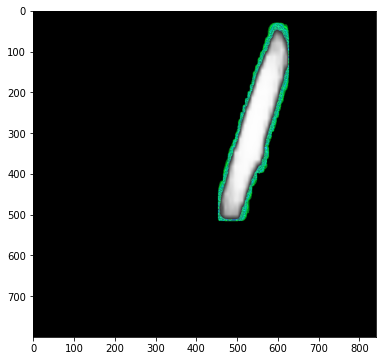

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(50)])[:, None] * palette
print(colors)
colors = (colors % 255).numpy().astype("uint8")
print(colors)

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(result[0]['masks'][0,0].mul(255).byte().cpu().numpy()).resize(im.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.imshow(r)

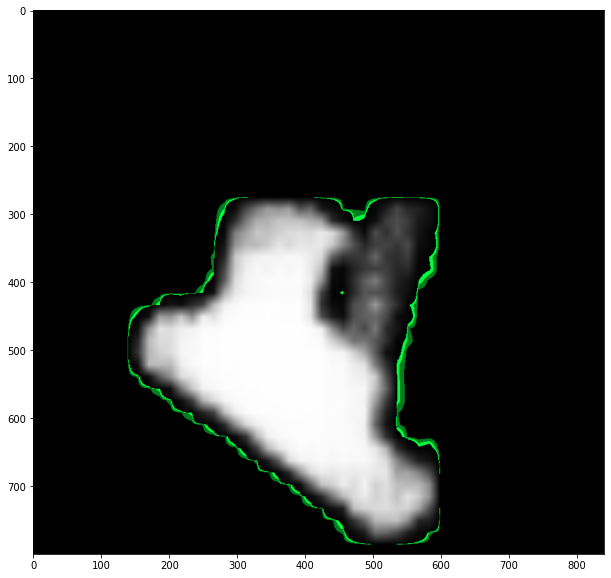

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(3)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(result[0]['masks'][1,0].mul(255).byte().cpu().numpy()).resize(im.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.imshow(r)

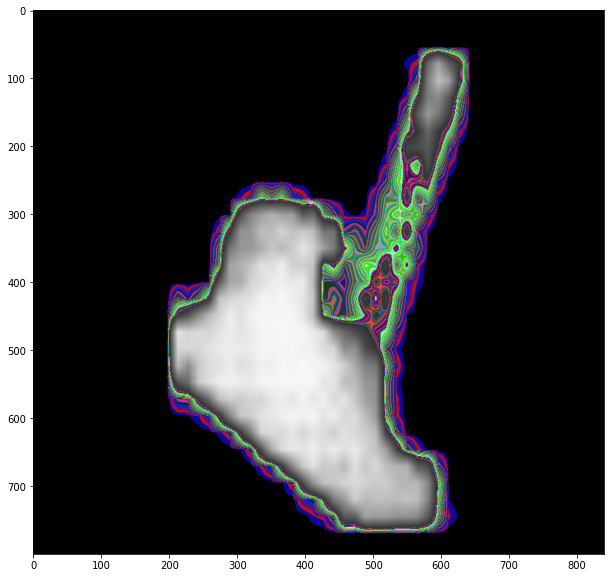

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(50)])[:, None] * palette
colors = (colors % 360).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(result[0]['masks'][2,0].mul(255).byte().cpu().numpy()).resize(im.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.imshow(r)

In [ ]:
# """
# Mask R-CNN
# Display and Visualization Functions.

# Copyright (c) 2017 Matterport, Inc.
# Licensed under the MIT License (see LICENSE for details)
# Written by Waleed Abdulla
# """

# import os
# import random
# import itertools
# import colorsys
# import numpy as np
# from skimage.measure import find_contours
# import matplotlib.pyplot as plt

# if "DISPLAY" not in os.environ:
#     plt.switch_backend('agg')

# import matplotlib.patches as patches
# import matplotlib.lines as lines
# from matplotlib.patches import Polygon



# def random_colors(N, bright=True):
#     """
#     Generate random colors.
#     To get visually distinct colors, generate them in HSV space then
#     convert to RGB.
#     """
#     brightness = 1.0 if bright else 0.7
#     hsv = [(i / N, 1, brightness) for i in range(N)]
#     colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
#     random.shuffle(colors)
#     return colors


# def apply_mask(image, mask, color, alpha=0.5):
#     """Apply the given mask to the image.
#     """
#     for c in range(3):
#         image[:, :, c] = np.where(mask == 1,
#                                   image[:, :, c] *
#                                   (1 - alpha) + alpha * color[c] * 255,
#                                   image[:, :, c])
#     return image


# def display_instances(image, boxes, masks, class_ids, class_names,
#                       scores=None, title="",
#                       figsize=(16, 16), ax=None):
#     """
#     boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
#     masks: [height, width, num_instances]
#     class_ids: [num_instances]
#     class_names: list of class names of the dataset
#     scores: (optional) confidence scores for each box
#     figsize: (optional) the size of the image.
#     """
#     # Number of instances
#     N = boxes.shape[0]
#     if not N:
#         print("\n*** No instances to display *** \n")
#     else:
#         assert boxes.shape[0] == masks.shape[0] == class_ids.shape[0]

#     if not ax:
#         _, ax = plt.subplots(1, figsize=figsize)

#     # Generate random colors
#     colors = random_colors(N)

#     # Show area outside image boundaries.
#     height, width = image.shape[:2]
#     ax.set_ylim(height + 10, -10)
#     ax.set_xlim(-10, width + 10)
#     ax.axis('off')
#     ax.set_title(title)

#     masked_image = image.astype(np.uint32).copy()
#     for i in range(N):
#         color = colors[i]

#         # Bounding box
#         if not np.any(boxes[i]):
#             # Skip this instance. Has no bbox. Likely lost in image cropping.
#             continue
#         y1, x1, y2, x2 = boxes[i]
#         p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
#                               alpha=0.7, linestyle="dashed",
#                               edgecolor=color, facecolor='none')
#         ax.add_patch(p)

#         # Label
#         class_id = class_ids[i]
#         score = scores[i] if scores is not None else None
#         label = class_names[class_id]
#         x = random.randint(x1, (x1 + x2) // 2)
#         caption = "{} {:.3f}".format(label, score) if score else label
#         ax.text(x1, y1 + 8, caption,
#                 color='w', size=11, backgroundcolor="none")

#         # Mask
#         mask = masks[:, :, i]
#         masked_image = apply_mask(masked_image, mask, color)

#         # Mask Polygon
#         # Pad to ensure proper polygons for masks that touch image edges.
#         padded_mask = np.zeros(
#             (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
#         padded_mask[1:-1, 1:-1] = mask
#         contours = find_contours(padded_mask, 0.5)
#         for verts in contours:
#             # Subtract the padding and flip (y, x) to (x, y)
#             verts = np.fliplr(verts) - 1
#             p = Polygon(verts, facecolor="none", edgecolor=color)
#             ax.add_patch(p)
#     ax.imshow(masked_image.astype(np.uint8))
#     plt.show()
    


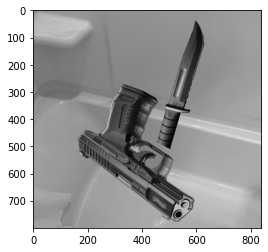

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# fname = '/content/gdrive/My Drive/maskrcnn_pistol_data1/images/00000161.png'
# image = Image.open(fname).convert("L")
# arr = np.asarray(image)
# plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
# plt.show()

In [ ]:
result[0]['masks'].shape

torch.Size([3, 1, 800, 840])

In [ ]:
# B, C, H, W = 3, 1, 800, 840
# x = torch.randn(B, C, H, W)
# y = torch.where(x > x.view(B, C, -1).mean(2)[:, :, None, None], torch.tensor([1.]), torch.tensor([0.]))

{'boxes': tensor([[456.5619,  39.1521, 623.8863, 507.7802],
        [147.2006, 284.5352, 590.8557, 777.1898],
        [206.2507,  67.1970, 633.7829, 756.7377]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 1, 2], device='cuda:0'), 'scores': tensor([0.9992, 0.9927, 0.2781], device='cuda:0', grad_fn=<IndexBackward>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,

TypeError: ignored

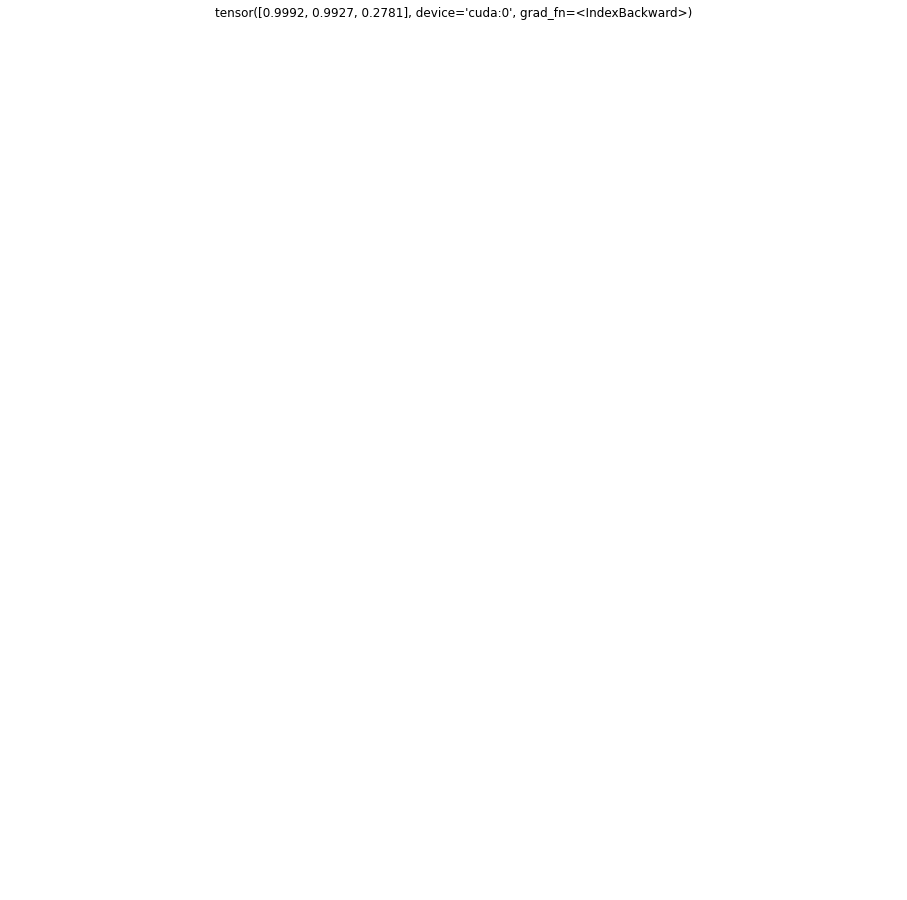

In [ ]:
# # Visualize results
# import skimage.io
# image = skimage.io.imread('/content/gdrive/My Drive/maskrcnn_pistol_data1/images/00000161.png')
# r = result[0]
# print(r)
# class_ids = [1,2]
# class_names = ['pistels','knifes']
# display_instances(image, r['boxes'], r['masks'], r['labels'],class_ids, class_names,r['scores'])
# plt.show()